In [1]:
import pandas as pd
import math
from collections import defaultdict, Counter
from tqdm import tqdm
import dgrec
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from datetime import date
import itertools
import mpltern
import os
import Library_00_Utils as utils
from scipy import stats



In [2]:
df_v2=pd.concat((utils.pickle_load('Pickle_Files\Genotypes\A_V2'),utils.pickle_load('Pickle_Files\Genotypes\B_V2')))
df_v2=df_v2[df_v2['count_total_geno']>1000]
df_v2_stats=utils.getting_percentage(utils.genotyping_dataframe(df_v2))
df_sorted_v2=df_v2_stats.sort_values(by='Percentage_muta_geno',ascending=False)

100%|██████████| 702/702 [00:00<00:00, 999.17it/s] 


# Positions where RT Passed (to determine the % of base A mutated)

In [3]:
def is_RT_passed(position, geno):
    """
    Determines whether the reverse transcriptase (bRT) passed on a given position.
    
    Parameters:
    position : int
        The position in the template sequence to evaluate.
        
    geno : tuple
        A tuple where the first element is a string of mutations (e.g., 'A3G, A4C, A32G'), and the second element is an integer representing the UMI count.
        
    Returns:
    bool
        True if there are mutations both before and after the given position, suggesting that RT has passed the position.
        False otherwise.
    """
    
    # Extract the list of mutations from the genotype string
    mut_list = geno[0].split(',')
    
    # Initialize counters for mutations before and after the given position
    mut_before_position = 0
    mut_after_position = 0
    
    # Loop through each mutation in the genotype
    for mut in mut_list:
        # Extract the mutation position (ignoring the bases)
        mut_pos = int(mut[1:-1])
        
        # Check if the mutation occurs before or after the given position
        if mut_pos < position:
            mut_before_position += 1  # Count mutations before the position
        elif mut_pos > position:
            mut_after_position += 1   # Count mutations after the position
    
    # Determine if there are mutations both before and after the position
    if mut_before_position > 0 and mut_after_position > 0:
        return True  # RT has passed the position (mutations found on both sides)
    else:
        return False  # RT has not passed the position (mutations on one or neither side)



def what_mutation_at_position(position, geno, TR):
    """
    Determines the type of mutation at a specific position in the template sequence.
    
    Parameters:
    position : int
        The position in the template sequence to evaluate.
        
    geno : tuple
        A tuple where the first element is a string of mutations (e.g., 'A3G'), and the second element is an integer representing the UMI count.
        
    TR : str
        The template sequence as a string of nucleotides.
        
    Returns:
    str
        The mutation at the specified position in the format 'OldBasePositionNewBase' (e.g., 'A3G').
        If no mutation is found at the position, returns the string of the form 'BasePositionBase', 
        indicating the original base at the position and surrounding context from the template sequence.
    """
    
    # Extract the list of mutations from the genotype string
    mut_list = geno[0].split(',')
    
    # Loop through each mutation in the list
    for mut in mut_list:
        # Extract the position of the mutation (ignoring the bases)
        mut_pos = int(mut[1:-1])
        
        # Check if the mutation position matches the specified position
        if mut_pos == position:
            return mut  # Return the mutation in the format 'OldBasePositionNewBase'
    
    # If no mutation is found at the specified position, return the original base information
    # Format: 'BasePositionBase' (e.g., 'A3A' for no mutation at position 3)
    return ''.join([TR[position], str(position), TR[position]])


In [4]:
# Initialize a defaultdict to store mutation data for positions where RT has passed
record_dic_RT_passed = defaultdict(list, {})

# Look only at the top 100 TRs
for k in tqdm(range(len(df_sorted_v2.head(100)))):
    # Extract the template sequence and genotype list for the current row
    TR = df_sorted_v2['TR'].iloc[k]
    geno_list = df_sorted_v2['geno_list'].iloc[k]

    # Filter genotypes to only include those with more than one mutation
    geno_2_muta = [geno for geno in geno_list if len(geno[0].split(',')) > 1]
    

    # Initialize a list to store genotypes that have passed RT
    RT_passed_genotypes = []
    
    # Loop through each genotype with multiple mutations
    for geno in geno_2_muta:
        mut_list = geno[0].split(',')  # List of individual mutations
        pos_list = [k[1:-1] for k in mut_list]  # List of positions of mutations
        
        # Loop through each position in the template (except the first and last one since we need to have >= 2 mutations)
        for position in range(1,69): 
            # Check if RT has passed this position for the current genotype
            if is_RT_passed(position, geno):
                # Get the mutation at the specified position
                mut = what_mutation_at_position(position, geno, TR)
                
                if mut != '':
                    old_base = mut[0]  # Original base
                    new_base = mut[-1]  # Mutated base
                    pos = int(mut[1:-1])  # Position of the mutation
                    
                    # Ensure the position is not too close to the edges of the template
                    if pos > 5 and pos < (len(TR) - 5):
                        # Store mutation data in the dictionary
                        record_dic_RT_passed['TR'].append(TR)
                        record_dic_RT_passed['Genotype'].append(geno[0])
                        record_dic_RT_passed['UMI Count'].append(geno[1])
                        record_dic_RT_passed['Old Base'].append(old_base)
                        record_dic_RT_passed['Position'].append(pos)
                        record_dic_RT_passed['New Base'].append(new_base)
                        
                        # Store upstream and downstream bases (-5 to +5 around the mutation)
                        for k in range(-5, 6):
                            record_dic_RT_passed[str(k)].append(TR[pos + k])
                        
                        # Check if the next three positions (+1 to +3) are also mutagenized
                        for j in range(1, 4):
                            pos_i_j = pos + j
                            if str(pos_i_j) in pos_list:
                                record_dic_RT_passed[f'Base +{j} mutagenized'].append(True)
                            else:
                                record_dic_RT_passed[f'Base +{j} mutagenized'].append(False)
                        
                        # Check if the previous three positions (-3 to -1) are also mutagenized
                        for j in range(-3, 0):
                            pos_i_j = pos + j
                            if str(pos_i_j) in pos_list:
                                record_dic_RT_passed[f'Base {j} mutagenized'].append(True)
                            else:
                                record_dic_RT_passed[f'Base {j} mutagenized'].append(False)

# Convert the dictionary of mutation data into a DataFrame
df_RT_passed_record_dic = pd.DataFrame(record_dic_RT_passed)

# Filter the DataFrame to include only rows where the new base is one of the standard nucleotides
df_RT_passed = df_RT_passed_record_dic[df_RT_passed_record_dic['New Base'].isin(['A', 'C', 'G', 'T'])]


100%|██████████| 100/100 [01:31<00:00,  1.10it/s]


# Mutations rates depending on the context

In [5]:
max_distance=15

df_to_analyze=df_RT_passed[(df_RT_passed['Old Base']=='A')]
record_dic_ratio_RT_passed=defaultdict(list,{})
for TR in tqdm(df_to_analyze['TR'].unique()):
    df_TR=df_to_analyze[df_to_analyze['TR']==TR]
    for position in df_TR['Position'].unique():
        if (position>max_distance) and (position<70-max_distance):
            df_TR_position=df_TR[df_TR['Position']==position]
            if len(df_TR_position)>10:
                
                record_dic_ratio_RT_passed['Position'].append(int(position))

                for k,base_k in enumerate(['A','C','G','T']):
                    df_TR_position_new_base=df_TR_position[df_TR_position['New Base']==base_k]

                    record_dic_ratio_RT_passed[f'Ratio {base_k}'].append((len(df_TR_position_new_base))/len(df_TR_position))
                for i in range(-max_distance,max_distance+1):
                            record_dic_ratio_RT_passed[f'Base {utils.if_postive_return_plus(i)}'].append(TR[int(position)+i])
df_ratio_RT_passed=pd.DataFrame(record_dic_ratio_RT_passed)


df_ratio_RT_passed["Mutagenesis Percentage"]=100*(1-df_ratio_RT_passed['Ratio A'] )
mutation_rate_on_A=list(df_ratio_RT_passed["Mutagenesis Percentage"])
mean_mutation_rate_on_A=np.mean(mutation_rate_on_A)
print(mean_mutation_rate_on_A)



100%|██████████| 100/100 [00:09<00:00, 10.88it/s]

30.464465686931398


In [6]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import pandas as pd

# Define the maximum distance for analysis around the mutation position
max_distance = 15

# Filter the DataFrame to include only rows where the old base is 'A'
df_to_analyze = df_RT_passed[df_RT_passed['Old Base'] == 'A']

# Initialize a defaultdict to store mutation ratio data
record_dic_ratio_RT_passed = defaultdict(list, {})

# Loop through each unique template sequence
for TR in tqdm(df_to_analyze['TR'].unique()):
    # Filter the DataFrame to include only rows for the current template sequence
    df_TR = df_to_analyze[df_to_analyze['TR'] == TR]
    
    # Loop through each unique position in the filtered DataFrame
    for position in df_TR['Position'].unique():
        # Only consider positions that are within the valid range
        if (position > max_distance) and (position < 70 - max_distance):
            # Filter the DataFrame to include only rows for the current position
            df_TR_position = df_TR[df_TR['Position'] == position]
            
            # Only process positions with more than 10 entries
            if len(df_TR_position) > 10:
                
                # Store the current position in the result dictionary
                record_dic_ratio_RT_passed['Position'].append(int(position))

                # Calculate the ratio of each new base incorporated at the current position
                for k, base_k in enumerate(['A', 'C', 'G', 'T']):
                    # Filter the DataFrame to include only rows where the new base matches the current base in the enumeration
                    df_TR_position_new_base = df_TR_position[df_TR_position['New Base'] == base_k]
                    
                    # Calculate the ratio of new base incorporated and store it in the result dictionary
                    record_dic_ratio_RT_passed[f'Ratio {base_k}'].append(len(df_TR_position_new_base) / len(df_TR_position))
                
                # Store the surrounding bases within the maximum distance
                for i in range(-max_distance, max_distance + 1):
                    # Get the surrounding base at the current position
                    base_at_position = TR[int(position) + i]
                    record_dic_ratio_RT_passed[f'Base {utils.if_postive_return_plus(i)}'].append(base_at_position)

# Convert the result dictionary into a DataFrame
df_ratio_RT_passed = pd.DataFrame(record_dic_ratio_RT_passed)

# Calculate the mutagenesis percentage as 100% minus the ratio of incorporation of a new base 'A' (A→A = no mutation)
df_ratio_RT_passed["Mutagenesis Percentage"] = 100 * (1 - df_ratio_RT_passed['Ratio A'])

# Extract the mutagenesis percentages into a list
mutation_rate_on_A = list(df_ratio_RT_passed["Mutagenesis Percentage"])

# Calculate the mean mutation rate on base 'A'
mean_mutation_rate_on_A = np.mean(mutation_rate_on_A)

# Print the mean mutation rate on base 'A'
print(mean_mutation_rate_on_A)


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]

30.464465686931398


### Long range effect

In [7]:
# Initialize a defaultdict to store results
record_dic = defaultdict(list, {})

# Loop over the range of context positions, excluding zero
for k in range(-max_distance, max_distance + 1):
    if k != 0:
        # Loop over each nucleotide base
        for base in ['A', 'C', 'G', 'T']:
            # Filter the DataFrame for rows where the base matches the current context base
            df_k_base = df_ratio_RT_passed[df_ratio_RT_passed[f'Base {utils.if_postive_return_plus(k)}'] == base]['Mutagenesis Percentage']
            
            # Calculate the mean mutagenesis percentage for the current context base
            mean_muta_percentage = df_k_base.mean()
            
            # Append the results to the dictionary
            record_dic['Context Position'].append(utils.if_postive_return_plus(k))
            record_dic['Context Base'].append(base)
            record_dic['Percentage of Mutated A'].append(mean_muta_percentage)
            
            # Perform a one-sample t-test comparing the mean mutagenesis percentage to the mean mutation rate on 'A'
            p_value = stats.ttest_1samp(list(df_k_base), popmean=mean_mutation_rate_on_A)[1]
            record_dic['P Value'].append(p_value)

# Convert the dictionary to a DataFrame
df_long_range = pd.DataFrame(record_dic)

# Apply Bonferroni correction to the p-values
df_long_range['P Value Bonferroni'] = utils.bonferroni_correction(list(df_long_range['P Value']))

# Convert corrected p-values to star notation
df_long_range['P Value Star'] = utils.p_value_to_stars(list(df_long_range['P Value Bonferroni']))


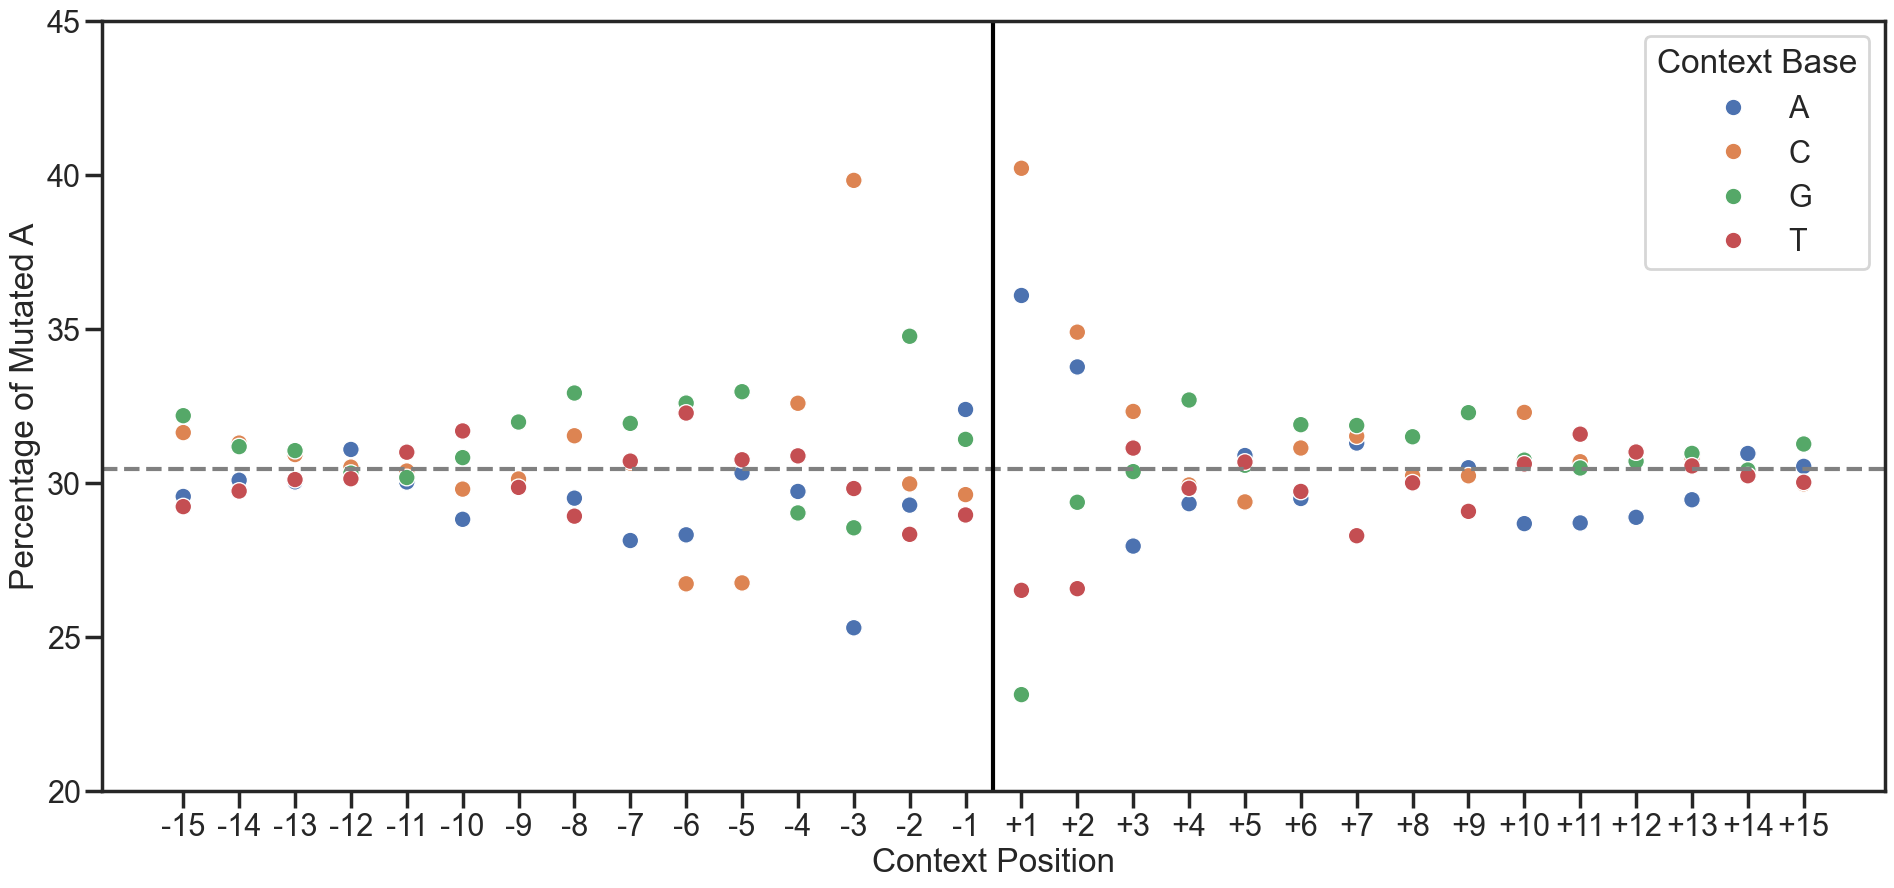

In [8]:
palette_ordered=[sns.color_palette().as_hex()[1],sns.color_palette().as_hex()[0],sns.color_palette().as_hex()[2],sns.color_palette().as_hex()[3]]
palette_ordered
plt.figure(figsize=(23,10))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')
sns.set_style('ticks')
sns.scatterplot(data=df_long_range,x='Context Position',y=f'Percentage of Mutated A',hue='Context Base')
plt.axhline(y=np.mean(mutation_rate_on_A), color='grey', linestyle='--',label=f'Average Percentage \nof A Mutagenized')
plt.ylim((20,45))
plt.axvline(x=max_distance-0.5,color='black')
plt.savefig(f'Figures/Long_Range_effect/Percentage_of_A_mutagenized_{max_distance}.png',dpi=600)
plt.savefig(f'Figures/Long_Range_effect/Percentage_of_A_mutagenized_{max_distance}.svg')
plt.show()

### Mutagenesis percentage from -5 to +5

In [9]:
# Calculate the mean mutation rate on base 'A'
mean_muta_rate = np.mean(mutation_rate_on_A)

# Initialize a defaultdict to store p-values for different base-context combinations
p_val_dic = defaultdict(list, {})

# Calculate p-values for each context position and base
for k in range(-5, 6):
    if k != 0:
        for base in ['A', 'C', 'G', 'T']:
            # Filter the DataFrame to get mutagenesis percentages for the current base at position k
            list_base = df_ratio_RT_passed[df_ratio_RT_passed[f'Base {utils.if_postive_return_plus(k)}'] == base]['Mutagenesis Percentage']
            
            # Perform a one-sample t-test to compare the mean mutagenesis percentage to the overall mean mutation rate
            p_value = stats.ttest_1samp(list_base, popmean=mean_muta_rate)[1]
            p_val_dic[f'Base {utils.if_postive_return_plus(k)}'].append(p_value)

# Apply Bonferroni correction and convert p-values to star notation
for key in p_val_dic:
    # Apply Bonferroni correction to account for multiple comparisons
    p_val_dic[key] = utils.bonferroni_correction(p_val_dic[key])
    
    # Convert corrected p-values to star notation for easier interpretation
    p_val_dic[key] = utils.p_value_to_stars(p_val_dic[key])


C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


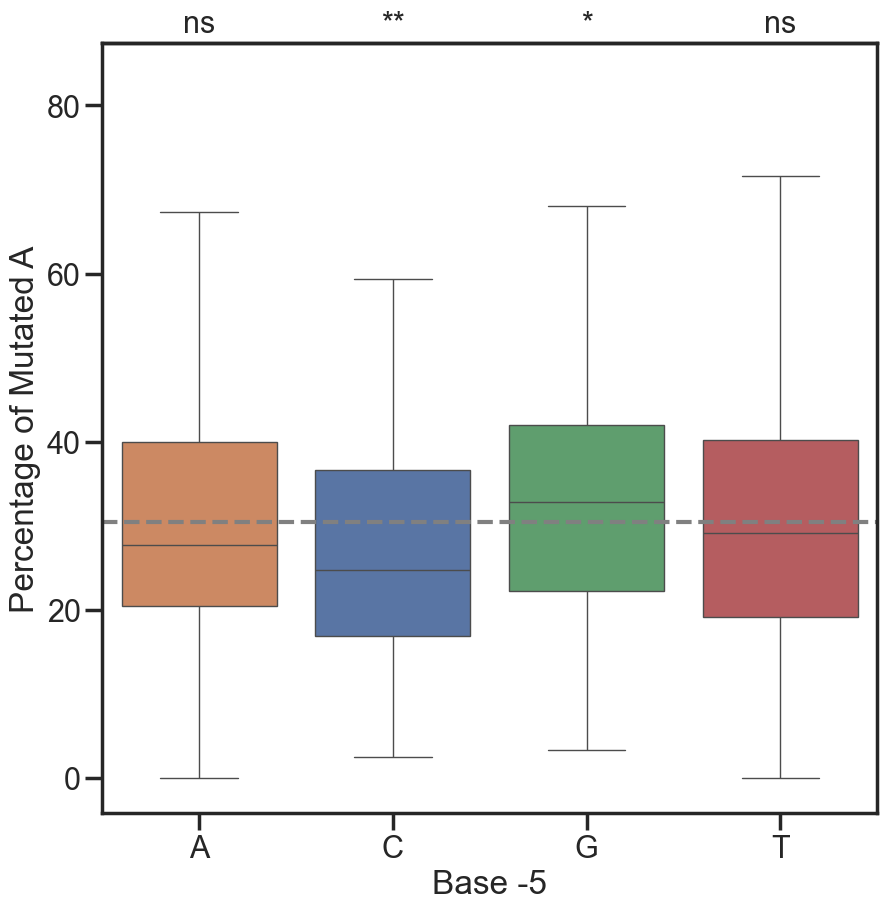

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


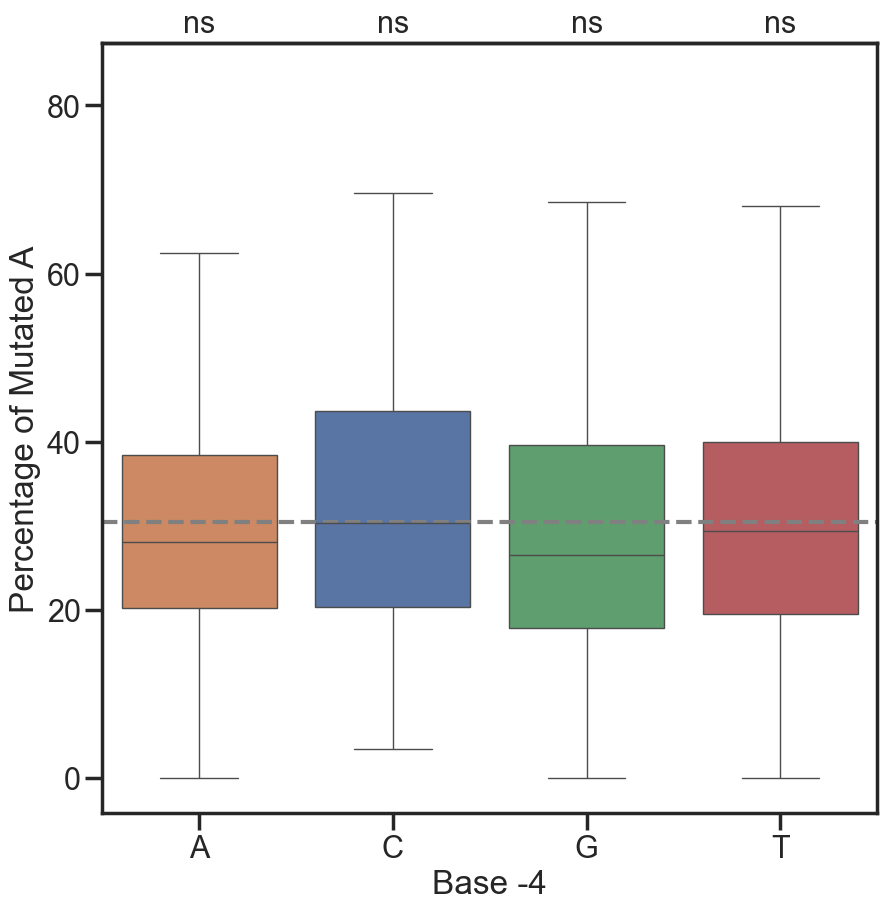

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


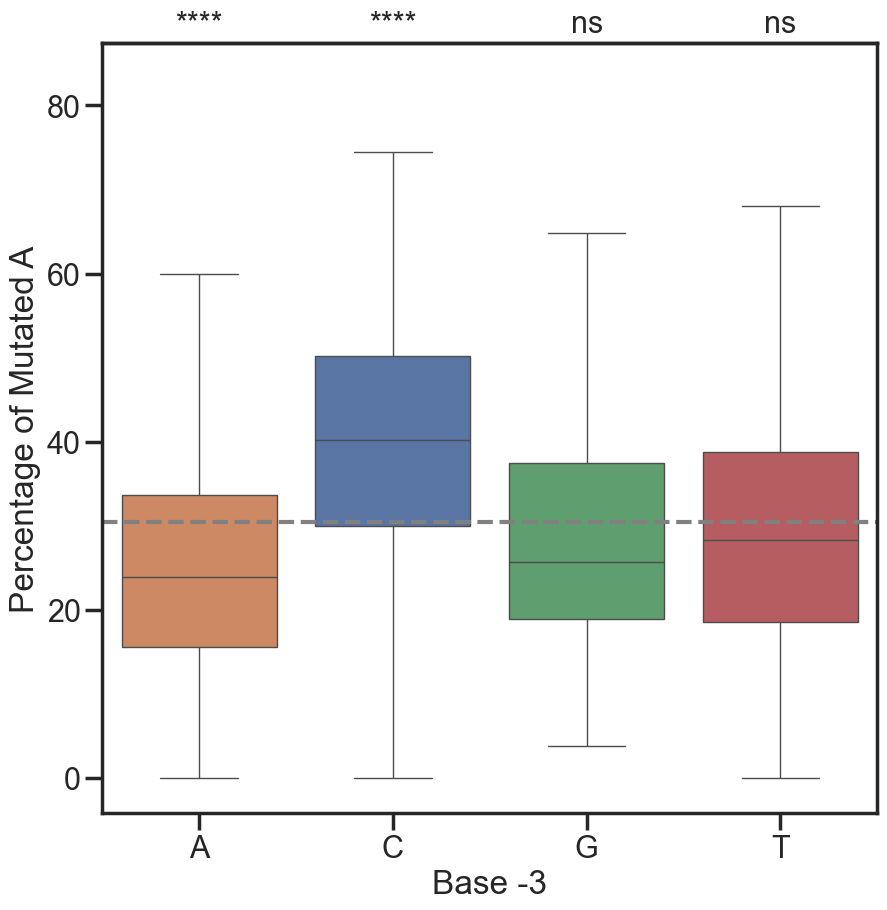

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


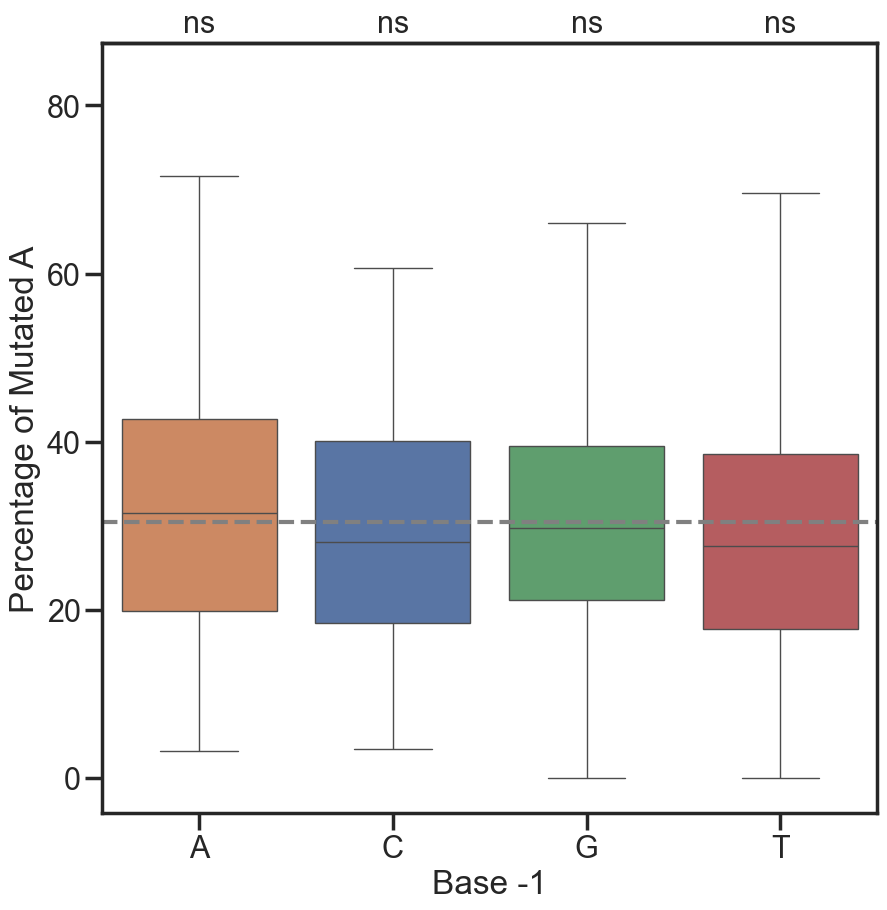

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


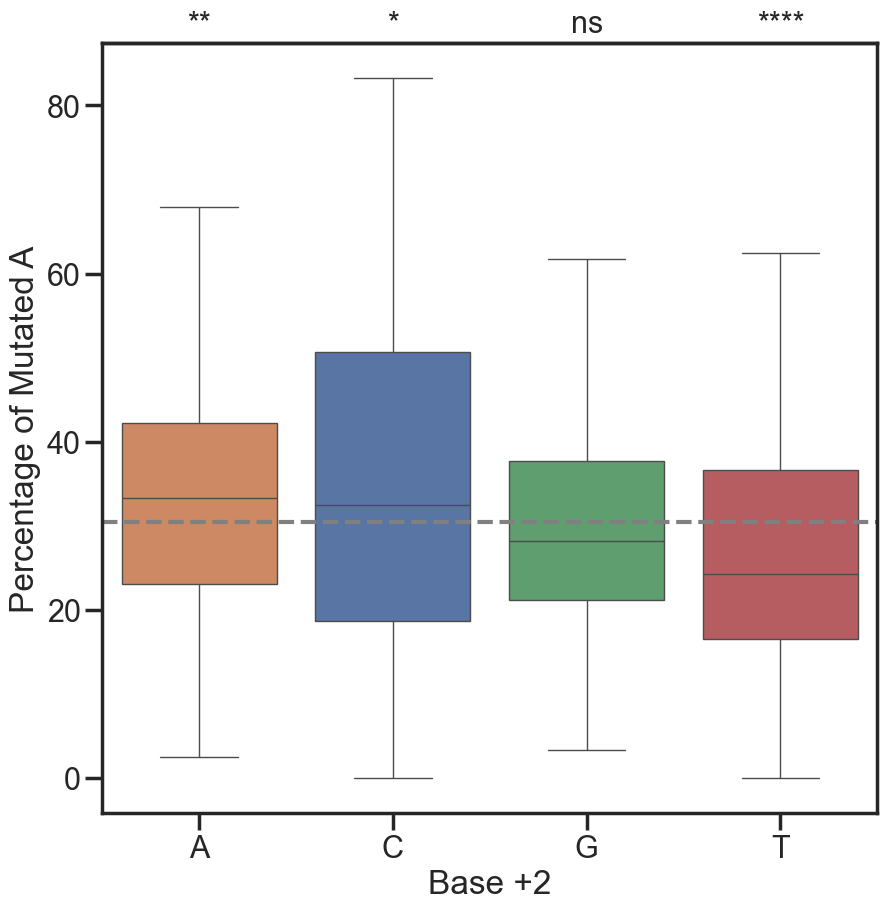

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


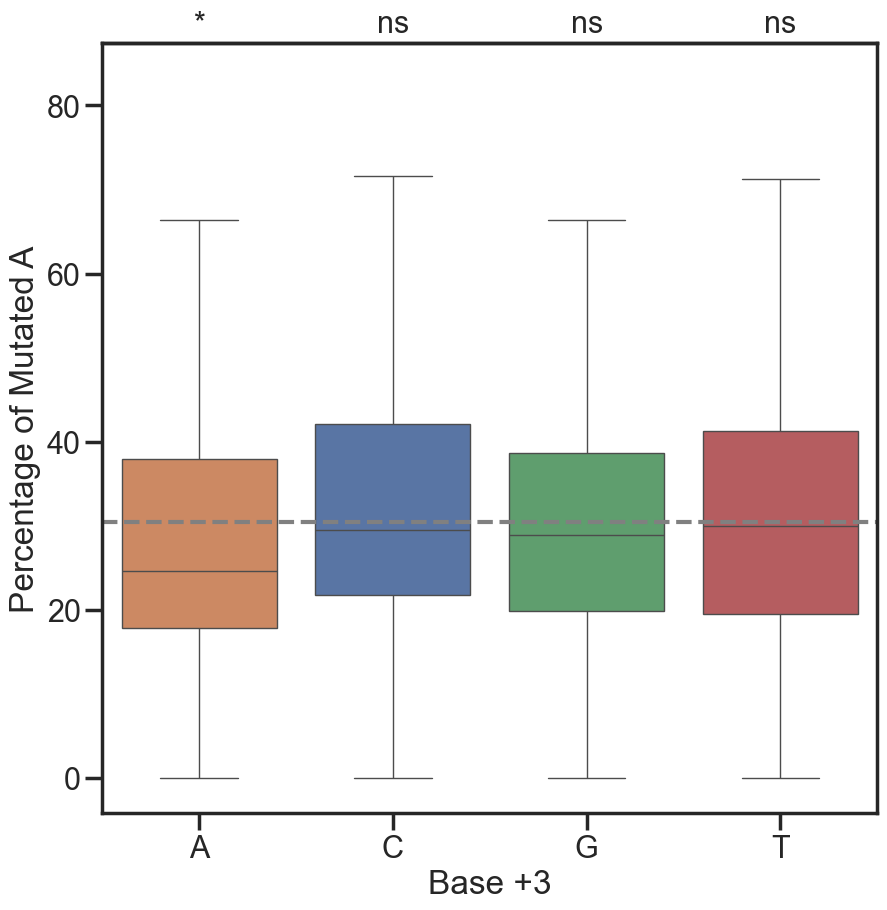

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


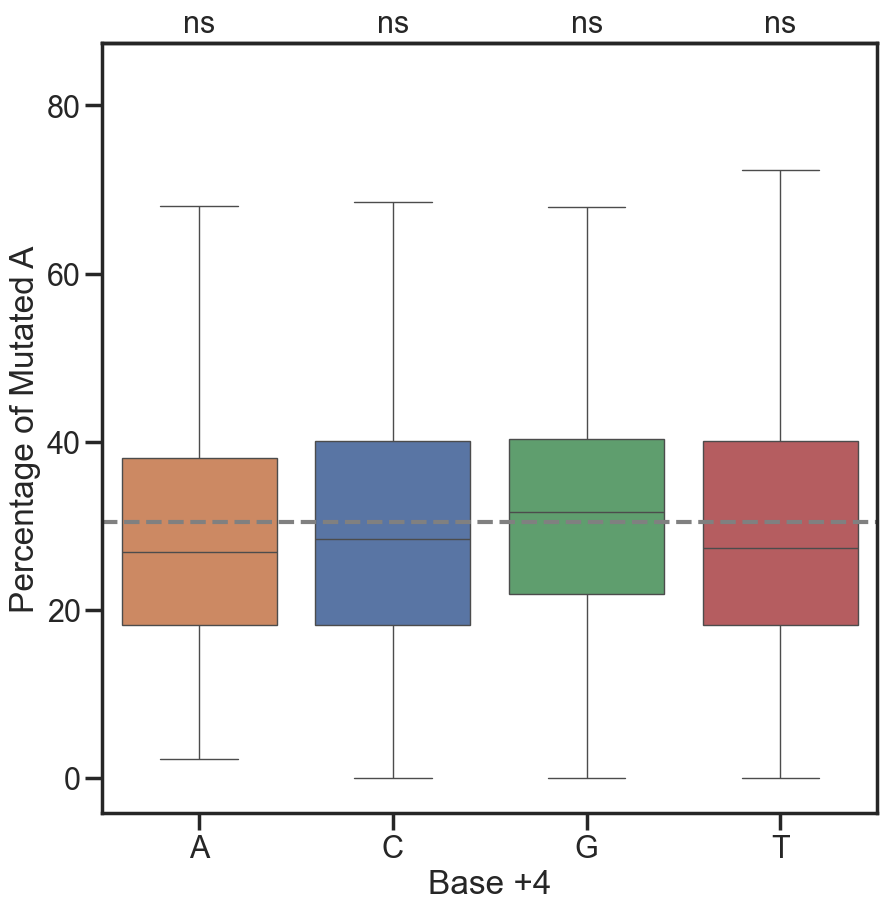

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1734417000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['A','C','G','T'])


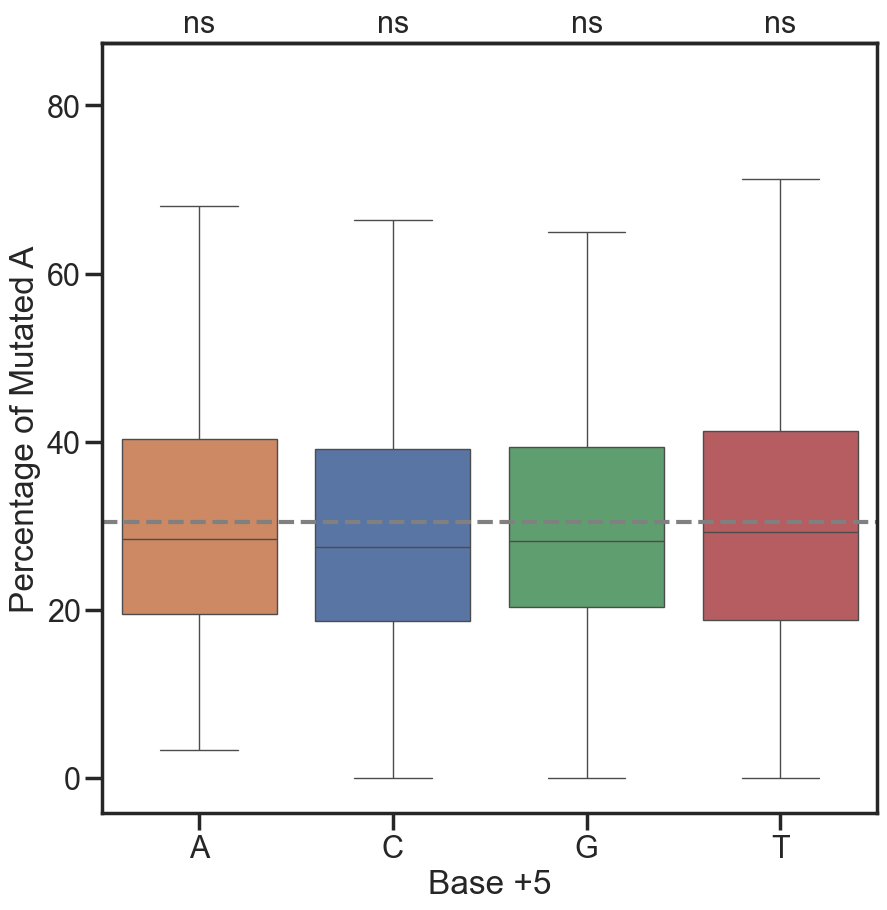

In [10]:
palette_ordered=[sns.color_palette().as_hex()[1],sns.color_palette().as_hex()[0],sns.color_palette().as_hex()[2],sns.color_palette().as_hex()[3]]
palette_ordered
plt.rcParams['svg.fonttype'] = 'none'
for k in range(-5,6):
    if k!=0:
        plt.figure(figsize=(10,10))
        sns.set_theme()
        sns.set_context("poster")
        sns.set_style('white')
        sns.set_style('ticks')
        ax=sns.boxplot(data=df_ratio_RT_passed.sort_values(by=f'Base {utils.if_postive_return_plus(k)}'),x=f'Base {utils.if_postive_return_plus(k)}',y='Mutagenesis Percentage',hue_order=('A','C','G','T'),hue=f'Base {utils.if_postive_return_plus(k)}',palette=palette_ordered,fliersize=0,dodge=False)
        plt.ylabel('Percentage of Mutated A')
        plt.axhline(y=mean_muta_rate,color='grey',linestyle='--')
        ax.set_xticklabels(['A','C','G','T'])
        ax_top = ax.secondary_xaxis('top')
        xtick_labels_top = p_val_dic[f'Base {utils.if_postive_return_plus(k)}']
        ax_top.set_xticks(range(len(xtick_labels_top)))
        ax_top.set_xticklabels(xtick_labels_top)
        ax_top.tick_params(axis='x', length=0)

        
        

        plt.savefig(f'Figures/Mutagenesis_Percentage/Base_{k}.svg')
        plt.savefig(f'Figures/Mutagenesis_Percentage/Base_{k}.png',dpi=600)
        plt.show()

### Mutagenesis percentage base combined (-1/-2) (+1/+2)

In [11]:
# Create new columns for combined base contexts
df_ratio_RT_passed['Base +1_Base +2'] = df_ratio_RT_passed['Base +1'] + df_ratio_RT_passed['Base +2']
df_ratio_RT_passed['Base -1_Base -2'] = df_ratio_RT_passed['Base -1'] + df_ratio_RT_passed['Base -2']
df_ratio_RT_passed['Base -1_Base +1'] = df_ratio_RT_passed['Base -1'] + df_ratio_RT_passed['Base +1']

# Define nucleotides and create dinucleotide combinations
nucleotides = ['A', 'C', 'G', 'T']
dinucleotides = [a + b for a, b in itertools.product(nucleotides, repeat=2)]

# Calculate the mean mutation rate on base 'A'
mean_muta_rate = np.mean(mutation_rate_on_A)

# Initialize lists to store p-values
p_val_1_2 = []
p_val_m1_m2 = []

# Calculate p-values for dinucleotide combinations in 'Base +1_Base +2'
for base in dinucleotides:
    # Filter DataFrame for the current dinucleotide combination
    list_base = df_ratio_RT_passed[df_ratio_RT_passed['Base +1_Base +2'] == base]['Mutagenesis Percentage']
    
    # Perform a one-sample t-test comparing the mean mutagenesis percentage to the overall mean mutation rate
    p_value = stats.ttest_1samp(list_base, popmean=mean_muta_rate)[1]
    p_val_1_2.append(p_value)

# Apply Bonferroni correction and convert p-values to star notation
p_val_1_2 = utils.bonferroni_correction(p_val_1_2)
p_val_1_2 = utils.p_value_to_stars(p_val_1_2)

# Calculate p-values for dinucleotide combinations in 'Base -1_Base -2'
for base in dinucleotides:
    # Filter DataFrame for the current dinucleotide combination
    list_base = df_ratio_RT_passed[df_ratio_RT_passed['Base -1_Base -2'] == base]['Mutagenesis Percentage']
    
    # Perform a one-sample t-test comparing the mean mutagenesis percentage to the overall mean mutation rate
    p_value = stats.ttest_1samp(list_base, popmean=mean_muta_rate)[1]
    p_val_m1_m2.append(p_value)

# Apply Bonferroni correction and convert p-values to star notation
p_val_m1_m2 = utils.bonferroni_correction(p_val_m1_m2)
p_val_m1_m2 = utils.p_value_to_stars(p_val_m1_m2)


#### Base -1/-2

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\1748052322.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dinucleotides)


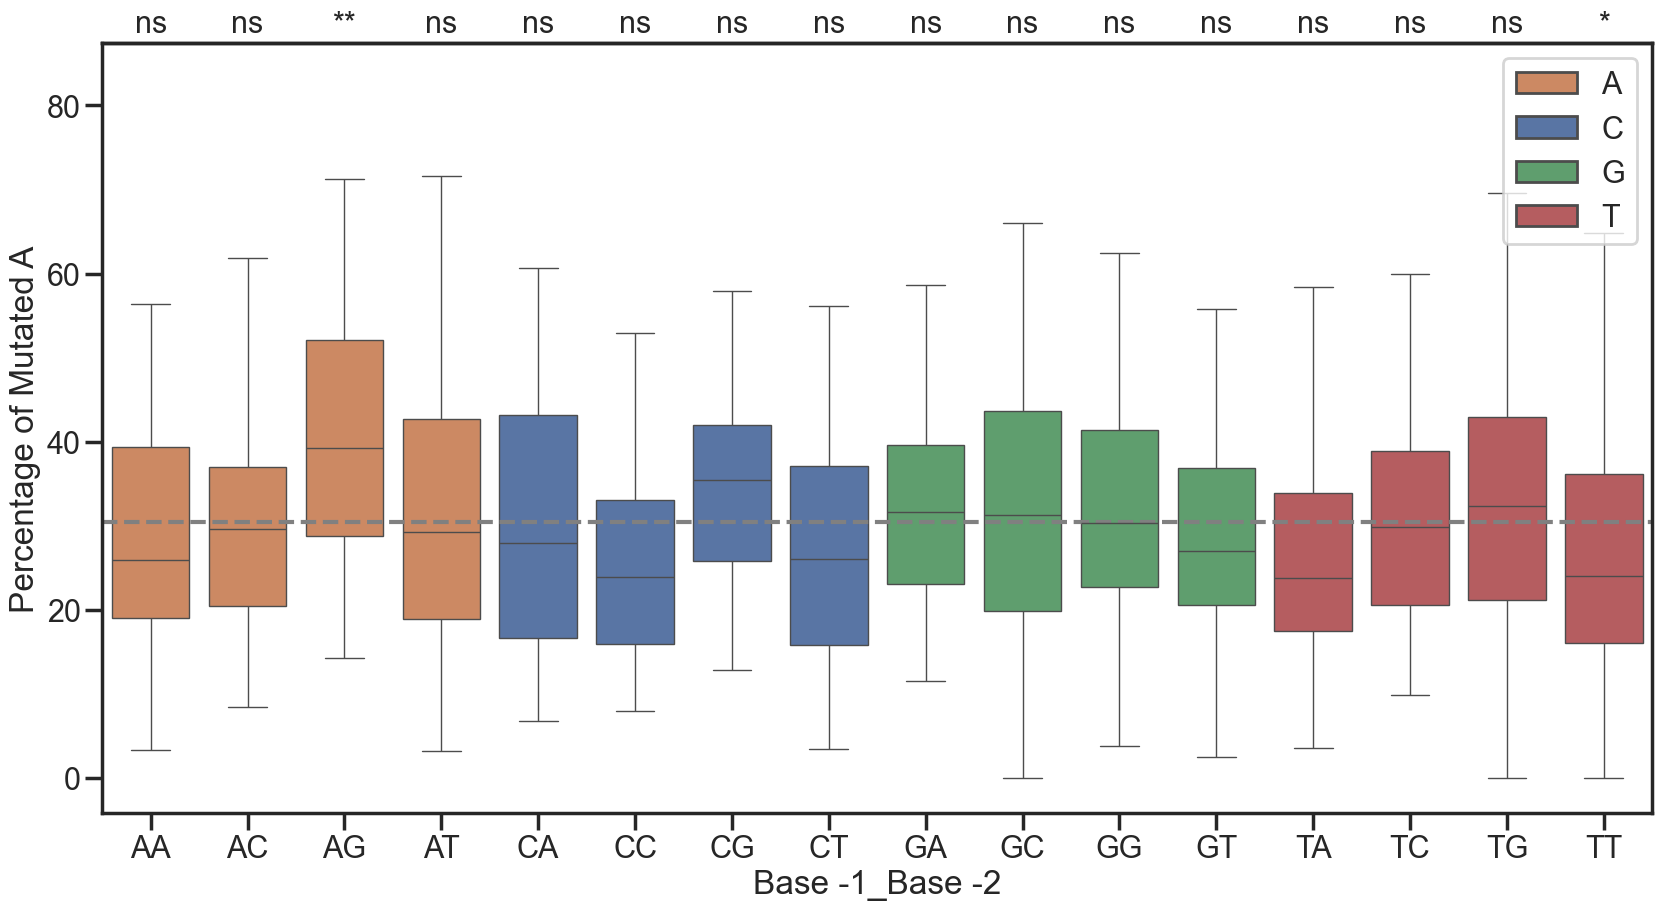

In [12]:
plt.figure(figsize=(20,10))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')
sns.set_style('ticks')
ax=sns.boxplot(data=df_ratio_RT_passed.sort_values(by='Base -1_Base -2'),x='Base -1_Base -2',y='Mutagenesis Percentage',hue_order=('A','C','G','T'),hue='Base -1',palette=palette_ordered,fliersize=0,dodge=False)

plt.ylabel('Percentage of Mutated A')

plt.axhline(y=mean_muta_rate,color='grey',linestyle='--')


ax.set_xticklabels(dinucleotides)
ax_top = ax.secondary_xaxis('top')
xtick_labels_top = p_val_m1_m2
ax_top.set_xticks(range(len(xtick_labels_top)))
ax_top.set_xticklabels(xtick_labels_top)
ax_top.tick_params(axis='x', length=0)
ax.legend(loc='upper right')

plt.savefig('Figures/Mutagenesis_Percentage/Base_-1_Base_-2.svg')
plt.savefig('Figures/Mutagenesis_Percentage/Base_-1_Base_-2.png',dpi=600)
plt.show()

#### Base +1/+2

C:\Users\prochett\AppData\Local\Temp\ipykernel_5148\3306973231.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dinucleotides)


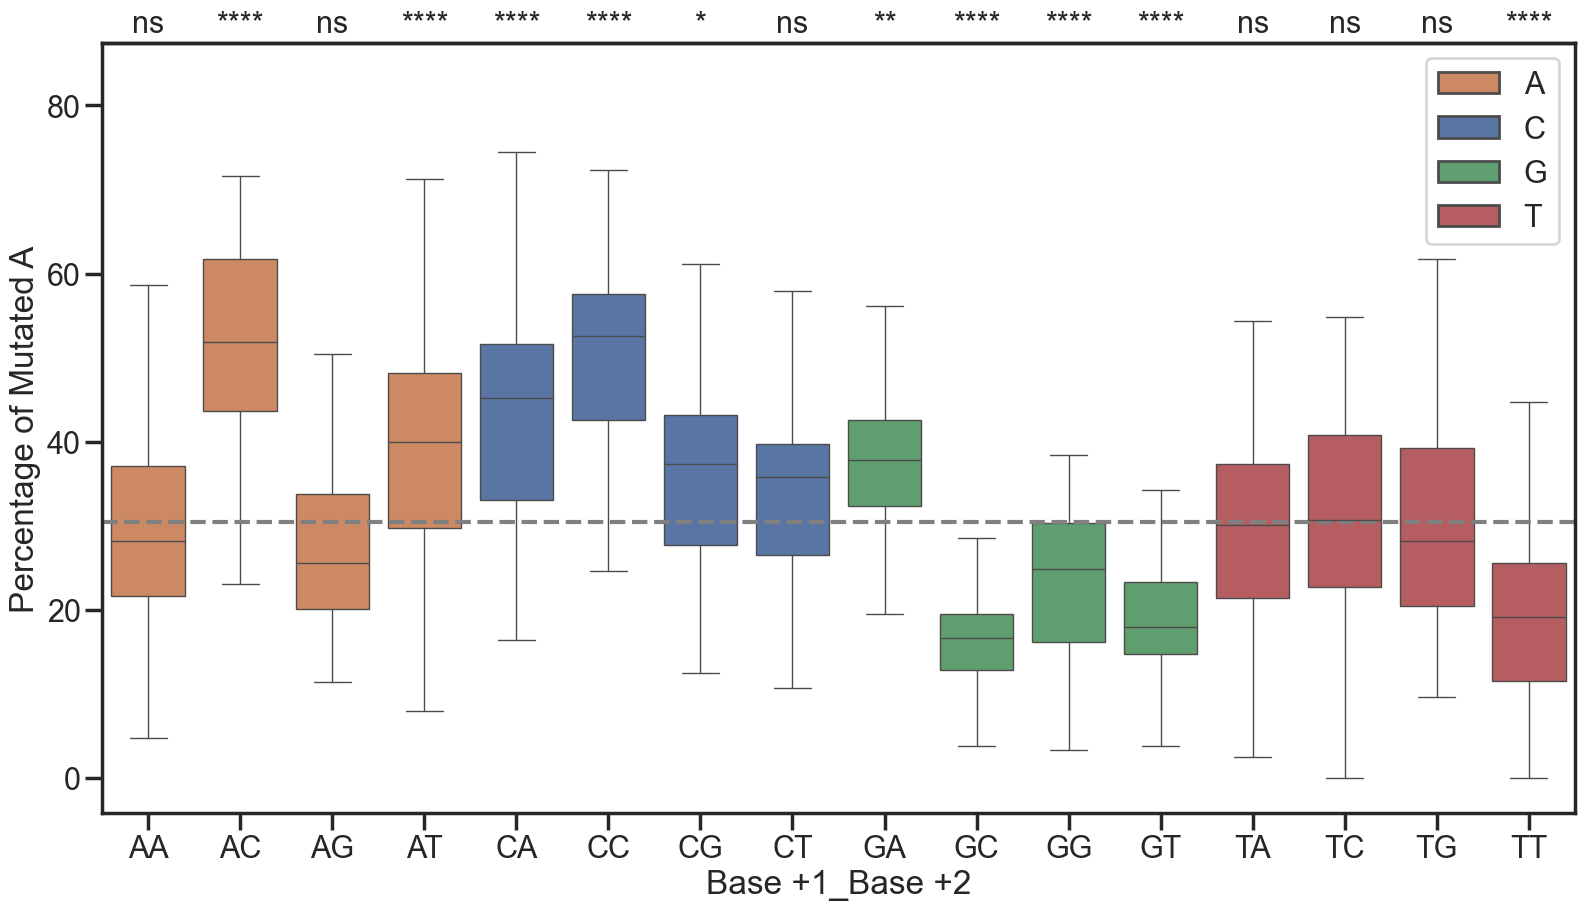

In [13]:
plt.figure(figsize=(19,10))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')
sns.set_style('ticks')
ax=sns.boxplot(data=df_ratio_RT_passed.sort_values(by='Base +1_Base +2'),x='Base +1_Base +2',y='Mutagenesis Percentage',hue_order=('A','C','G','T'),hue='Base +1',palette=palette_ordered,fliersize=0,dodge=False)

plt.axhline(y=mean_muta_rate,color='grey',linestyle='--')
ax.set_xticklabels(dinucleotides)
ax_top = ax.secondary_xaxis('top')
xtick_labels_top = p_val_1_2
ax_top.set_xticks(range(len(xtick_labels_top)))
ax_top.set_xticklabels(xtick_labels_top)
ax_top.tick_params(axis='x', length=0)
ax.legend(loc='upper right')


plt.ylabel('Percentage of Mutated A')
plt.savefig('Figures/Mutagenesis_Percentage/Base_1_Base_2.svg')
plt.savefig('Figures/Mutagenesis_Percentage/Base_1_Base_2.png',dpi=600)
plt.show()

# Snowball effect (mutagenesis percentage if a precedent base is mutagenized)

### Snowball effect on A

In [14]:

# Define the lists of positions and mutation statuses to analyze
Plus_list = ['+1', '+2']
Mutated_list = [False, True]

# Initialize a defaultdict to store the results
record_dic_snowball_A = defaultdict(list, {})

# Iterate over each combination of position and mutation status
for plus in Plus_list:
    for mutated in Mutated_list:
        # Filter the DataFrame for the current combination of position and mutation status + only look at old bases == A
        df_to_analyze = df_RT_passed[
            (df_RT_passed['Old Base'] == 'A') & (df_RT_passed[f'Base {plus} mutagenized'] == mutated)
        ]

        # Initialize a defaultdict to store ratios for the current combination
        record_dic_ratio_k = defaultdict(list, {})

        # Analyze each unique TR in the filtered DataFrame
        for TR in tqdm(df_to_analyze['TR'].unique()):
            df_TR = df_to_analyze[df_to_analyze['TR'] == TR]

            # Analyze each unique position in the TR DataFrame
            for position in df_TR['Position'].unique():
                df_TR_position = df_TR[df_TR['Position'] == position]

                # Only analyze if there are more than 10 records
                if len(df_TR_position) > 10:
                    # Record the position
                    record_dic_ratio_k['Position'].append(int(position))

                    # Calculate the ratio of occurrences for each base
                    for base_k in ['A', 'C', 'G', 'T']:
                        df_TR_position_new_base = df_TR_position[df_TR_position['New Base'] == base_k]
                        record_dic_ratio_k[f'Ratio {base_k}'].append(
                            len(df_TR_position_new_base) / len(df_TR_position)
                        )

        # Convert the results to a DataFrame
        df_ratio = pd.DataFrame(record_dic_ratio_k)

        # Calculate the mutagenesis percentage based on the ratio of base 'A'
        df_ratio["Mutagenesis Percentage"] = 100 * (1 - df_ratio['Ratio A'])
        mutation_rate_on_A = list(df_ratio["Mutagenesis Percentage"])

        # Extend the record dictionary with the results
        record_dic_snowball_A['Percentage of A Mutated'].extend(mutation_rate_on_A)
        record_dic_snowball_A['Position'].extend([plus] * len(mutation_rate_on_A))
        record_dic_snowball_A['Mutated'].extend([mutated] * len(mutation_rate_on_A))

# Convert the results to a DataFrame
df_snowball_A = pd.DataFrame(record_dic_snowball_A)

# Perform t-tests comparing mutated vs. non-mutated percentages for positions +1 and +2
t_test_1_A = stats.ttest_ind(
    list(df_snowball_A[(df_snowball_A['Position'] == '+1') & (df_snowball_A['Mutated'] == True)]['Percentage of A Mutated']),
    list(df_snowball_A[(df_snowball_A['Position'] == '+1') & (df_snowball_A['Mutated'] == False)]['Percentage of A Mutated'])
)
t_test_2_A = stats.ttest_ind(
    list(df_snowball_A[(df_snowball_A['Position'] == '+2') & (df_snowball_A['Mutated'] == True)]['Percentage of A Mutated']),
    list(df_snowball_A[(df_snowball_A['Position'] == '+2') & (df_snowball_A['Mutated'] == False)]['Percentage of A Mutated'])
)

# Print the results of the t-tests with p-values converted to star notation
print('T Test +1 Snowball A =', t_test_1_A[1], utils.p_value_to_stars([t_test_1_A[1]]))
print('T Test +2 Snowball A =', t_test_2_A[1], utils.p_value_to_stars([t_test_2_A[1]]))

# Convert p-values to star notation
p_value_snowball_A = utils.p_value_to_stars([t_test_1_A[1], t_test_2_A[1]])


100%|██████████| 100/100 [00:01<00:00, 59.38it/s]

T Test +1 Snowball A = 4.318558428054828e-158 ['****']
T Test +2 Snowball A = 0.00012165179448142999 ['***']


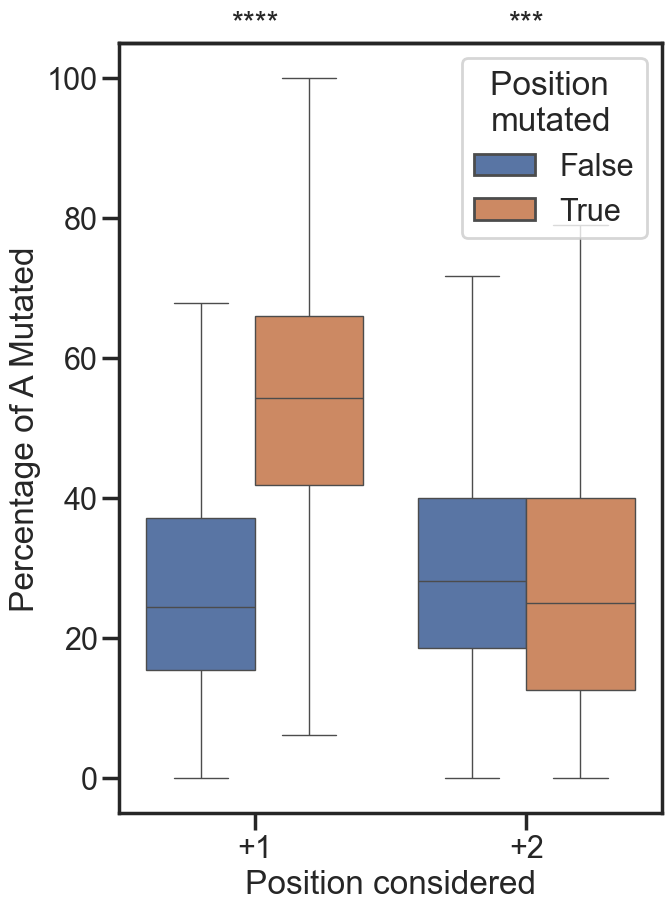

In [15]:
plt.figure(figsize=(7,10))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')
sns.set_style('ticks')
ax=sns.boxplot(data=df_snowball_A,x='Position',y='Percentage of A Mutated',hue='Mutated',fliersize=0)

ax_top = ax.secondary_xaxis('top')
xtick_labels_top = p_value_snowball_A
ax_top.set_xticks([0,1])
ax_top.set_xticklabels(xtick_labels_top)
ax_top.tick_params(axis='x', length=0)

plt.legend(title='Position \nmutated',loc='upper right')
plt.xlabel('Position considered')
plt.savefig('Figures/Snowball/Snowball_A.svg')
plt.savefig('Figures/Snowball/Snowball_A.png',dpi=600)
plt.show()


### Snowball effect on T

In [16]:
# Define the lists of positions and mutation statuses to analyze
Plus_list = ['+1', '+2']
Mutated_list = [False, True]

# Initialize a defaultdict to store results for base 'T'
record_dic_snowball_T = defaultdict(list, {})

# Iterate over each combination of position and mutation status
for plus in Plus_list:
    for mutated in Mutated_list:
        # Filter the DataFrame for the current combination of position and mutation status + only look at old bases == T
        df_to_analyze = df_RT_passed[
            (df_RT_passed['Old Base'] == 'T') & (df_RT_passed[f'Base {plus} mutagenized'] == mutated)
        ]

        # Initialize a defaultdict to store ratios for the current combination
        record_dic_ratio_k = defaultdict(list, {})

        # Analyze each unique TR in the filtered DataFrame
        for TR in tqdm(df_to_analyze['TR'].unique()):
            df_TR = df_to_analyze[df_to_analyze['TR'] == TR]

            # Analyze each unique position in the TR DataFrame
            for position in df_TR['Position'].unique():
                df_TR_position = df_TR[df_TR['Position'] == position]

                # Only analyze if there are more than 10 records
                if len(df_TR_position) > 10:
                    # Record the position
                    record_dic_ratio_k['Position'].append(int(position))

                    # Calculate the ratio of occurrences for each base
                    for base_k in ['A', 'C', 'G', 'T']:
                        df_TR_position_new_base = df_TR_position[df_TR_position['New Base'] == base_k]
                        record_dic_ratio_k[f'Ratio {base_k}'].append(
                            len(df_TR_position_new_base) / len(df_TR_position)
                        )

        # Convert the results to a DataFrame
        df_ratio = pd.DataFrame(record_dic_ratio_k)

        # Calculate the mutagenesis percentage based on the ratio of base 'T'
        df_ratio["Mutagenesis Percentage"] = 100 * (1 - df_ratio['Ratio T'])
        mutation_rate_on_T = list(df_ratio["Mutagenesis Percentage"])

        # Extend the record dictionary with the results
        record_dic_snowball_T['Percentage of T Mutated'].extend(mutation_rate_on_T)
        record_dic_snowball_T['Position'].extend([plus] * len(mutation_rate_on_T))
        record_dic_snowball_T['Mutated'].extend([mutated] * len(mutation_rate_on_T))

# Convert the results to a DataFrame
df_snowball_T = pd.DataFrame(record_dic_snowball_T)

# Perform t-tests comparing mutated vs. non-mutated percentages for positions +1 and +2
t_test_1_T = stats.ttest_ind(
    list(df_snowball_T[(df_snowball_T['Position'] == '+1') & (df_snowball_T['Mutated'] == True)]['Percentage of T Mutated']),
    list(df_snowball_T[(df_snowball_T['Position'] == '+1') & (df_snowball_T['Mutated'] == False)]['Percentage of T Mutated'])
)
t_test_2_T = stats.ttest_ind(
    list(df_snowball_T[(df_snowball_T['Position'] == '+2') & (df_snowball_T['Mutated'] == True)]['Percentage of T Mutated']),
    list(df_snowball_T[(df_snowball_T['Position'] == '+2') & (df_snowball_T['Mutated'] == False)]['Percentage of T Mutated'])
)

# Print the results of the t-tests with p-values converted to star notation
print('T Test +1 Snowball T =', t_test_1_T[1], utils.p_value_to_stars([t_test_1_T[1]]))
print('T Test +2 Snowball T =', t_test_2_T[1], utils.p_value_to_stars([t_test_2_T[1]]))

# Convert p-values to star notation
p_value_snowball_T = utils.p_value_to_stars([t_test_1_T[1], t_test_2_T[1]])
p_value_snowball_T


100%|██████████| 100/100 [00:02<00:00, 46.13it/s]


T Test +1 Snowball T = 4.1952474541988184e-32 ['****']
T Test +2 Snowball T = 1.4485077731946082e-10 ['****']


['****', '****']

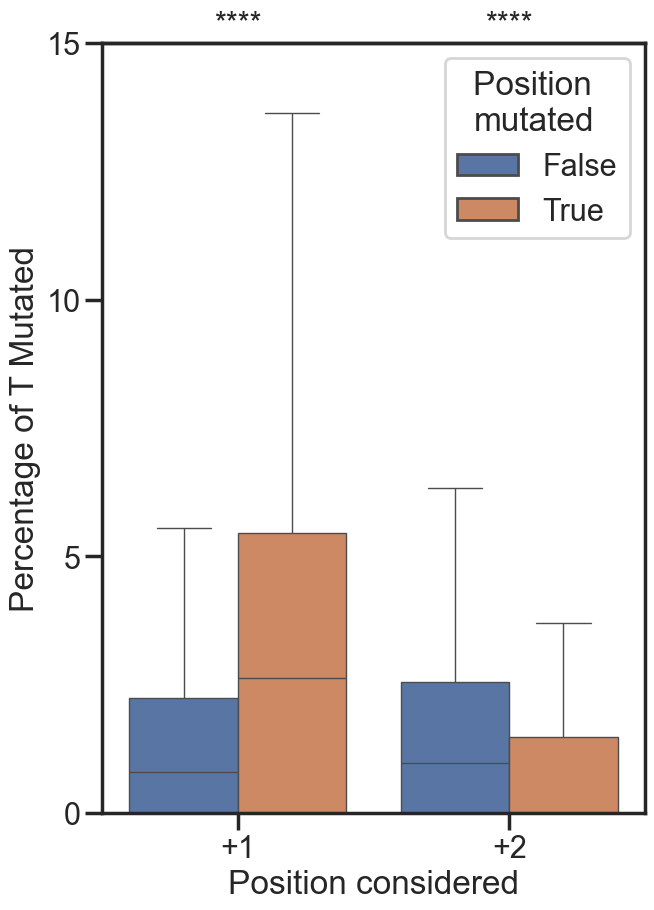

In [17]:
plt.figure(figsize=(7,10))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')
sns.set_style('ticks')
ax=sns.boxplot(data=df_snowball_T,x='Position',y='Percentage of T Mutated',hue='Mutated',fliersize=0)

ax_top = ax.secondary_xaxis('top')
xtick_labels_top = p_value_snowball_T
ax_top.set_xticks([0,1])
ax_top.set_xticklabels(xtick_labels_top)
ax_top.tick_params(axis='x', length=0)

plt.legend(title='Position \nmutated',loc='upper right')
plt.xlabel('Position considered')
plt.ylim((0,15))
ax.set_yticks([0,5,10,15])
plt.savefig('Figures/Snowball/Snowball_T.svg')
plt.savefig('Figures/Snowball/Snowball_T.png',dpi=600)
plt.show()


# Plot the codon table

In [18]:
genetic_code = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

In [19]:
from collections import defaultdict
import numpy as np
import pandas as pd

def proba_evolution_base_1(codon):
    """
    Calculate the probabilities of evolving to each possible new base at position 1,
    given the current codon.

    Parameters:
    - codon: A string of length 3, representing the current codon.

    Returns:
    - A dictionary with bases 'A', 'C', 'G', 'T' and their respective probabilities.
    """
    # Filter DataFrame for codons with the specified bases
    df_codon = df_RT_passed[(df_RT_passed['Old Base'] == codon[0]) & 
                            (df_RT_passed['1'] == codon[1]) & 
                            (df_RT_passed['2'] == codon[2])]
    proba_dic = {}
    # Calculate the probability of each new base
    for base in ['A', 'C', 'G', 'T']:
        proba_base = len(df_codon[df_codon['New Base'] == base]) / len(df_codon)
        proba_dic[base] = proba_base
    return proba_dic

def proba_evolution_base_2(codon):
    """
    Calculate the probabilities of evolving to each possible new base at position 2,
    given the current codon.

    Parameters:
    - codon: A string of length 3, representing the current codon.

    Returns:
    - A dictionary with bases 'A', 'C', 'G', 'T' and their respective probabilities.
    """
    # Filter DataFrame for codons with the specified bases
    df_codon = df_RT_passed[(df_RT_passed['-1'] == codon[0]) & 
                            (df_RT_passed['Old Base'] == codon[1]) & 
                            (df_RT_passed['1'] == codon[2])]
    proba_dic = {}
    # Calculate the probability of each new base
    for base in ['A', 'C', 'G', 'T']:
        proba_base = len(df_codon[df_codon['New Base'] == base]) / len(df_codon)
        proba_dic[base] = proba_base
    return proba_dic

def proba_evolution_base_3(codon):
    """
    Calculate the probabilities of evolving to each possible new base at position 3,
    given the current codon.

    Parameters:
    - codon: A string of length 3, representing the current codon.

    Returns:
    - A dictionary with bases 'A', 'C', 'G', 'T' and their respective probabilities.
    """
    # Filter DataFrame for codons with the specified bases
    df_codon = df_RT_passed[(df_RT_passed['-2'] == codon[0]) & 
                            (df_RT_passed['-1'] == codon[1]) & 
                            (df_RT_passed['Old Base'] == codon[2])]
    proba_dic = {}
    # Calculate the probability of each new base
    for base in ['A', 'C', 'G', 'T']:
        proba_base = len(df_codon[df_codon['New Base'] == base]) / len(df_codon)
        proba_dic[base] = proba_base
    return proba_dic

def evolve_codon_DNA(codon):
    """
    Compute the probability of evolving to each possible new codon 
    given the initial codon.

    Parameters:
    - codon: A string of length 3, representing the current codon.

    Returns:
    - A dictionary with new codons and their respective probabilities.
    """
    proba_dic = defaultdict(np.float64)
    # Get probabilities for each base at positions 1, 2, and 3
    proba_base_1 = proba_evolution_base_1(codon)
    proba_base_2 = proba_evolution_base_2(codon)
    proba_base_3 = proba_evolution_base_3(codon)
    # Calculate the probability of each new codon
    for base_1 in ['A', 'C', 'G', 'T']:
        for base_2 in ['A', 'C', 'G', 'T']:
            for base_3 in ['A', 'C', 'G', 'T']:
                new_codon = base_1 + base_2 + base_3
                new_codon_proba = (proba_base_1[base_1] *
                                   proba_base_2[base_2] *
                                   proba_base_3[base_3])
                proba_dic[new_codon] = new_codon_proba
    return proba_dic

def evolve_codon_prot(codon):
    """
    Compute the probability of evolving to each amino acid 
    given the initial codon.

    Parameters:
    - codon: A string of length 3, representing the current codon.

    Returns:
    - A dictionary with amino acids and their respective probabilities.
    """
    proba_dic_dna = evolve_codon_DNA(codon)
    proba_dic_prot = defaultdict(np.float64)
    # Convert codon probabilities to amino acid probabilities
    for new_codon in proba_dic_dna:
        proba_dic_prot[genetic_code[new_codon]] += proba_dic_dna[new_codon]
    return proba_dic_prot


In [20]:
# Initialize dictionaries to store probabilities for DNA and protein evolution
record_dic_DNA = defaultdict(list, {})
record_dic_prot = defaultdict(list, {})

# Create a progress bar for tracking the iteration progress
progress_bar = tqdm(total=64)

# Iterate over all possible combinations of base triplets for codons
for base_1 in ['A', 'C', 'G', 'T']:
    for base_2 in ['A', 'C', 'G', 'T']:
        for base_3 in ['A', 'C', 'G', 'T']:
            # Combine bases to form a codon
            start_codon = base_1 + base_2 + base_3
            
            # Compute the probabilities of evolving to new codons and amino acids
            proba_dic_dna = evolve_codon_DNA(start_codon)
            proba_dic_prot = evolve_codon_prot(start_codon)
            
            # Record the start codon and its probabilities
            record_dic_DNA['Start Codon'].append(start_codon)
            record_dic_prot['Start Codon'].append(start_codon)
            
            # Append DNA probabilities to the dictionary
            for key in proba_dic_dna:
                record_dic_DNA[key].append(proba_dic_dna[key])
            
            # Append protein probabilities to the dictionary
            for key in proba_dic_prot:
                record_dic_prot[key].append(proba_dic_prot[key])
            
            # Update the progress bar
            progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# Convert the dictionaries to DataFrames
df_proba_DNA = pd.DataFrame(record_dic_DNA)
df_proba_prot = pd.DataFrame(record_dic_prot)

# Save the DataFrames to pickle files
utils.pickle_save(df_proba_DNA, 'Pickle_Files/Codons_Proba_Evolution/df_proba_DNA')
utils.pickle_save(df_proba_prot, 'Pickle_Files/Codons_Proba_Evolution/df_proba_prot')


# df_proba_DNA=utils.pickle_load('Pickle_Files/Codons_Proba_Evolution/df_proba_DNA')
# df_proba_prot=utils.pickle_load('Pickle_Files/Codons_Proba_Evolution/df_proba_prot')
df_proba_prot_index=df_proba_prot.set_index('Start Codon')

100%|██████████| 64/64 [05:19<00:00,  4.99s/it]


In [21]:
# record_dic_DNA=defaultdict(list,{})
# record_dic_prot=defaultdict(list,{})
# progress_bar = tqdm(total=64)

# for base_1 in ['A','C','G','T']:
#     for base_2 in ['A','C','G','T']:
#         for base_3 in ['A','C','G','T']:
#             start_codon=base_1+base_2+base_3
#             proba_dic_dna=evolve_codon_DNA(start_codon)
#             proba_dic_prot=evolve_codon_prot(start_codon)
#             record_dic_DNA['Start Codon'].append(start_codon)
#             record_dic_prot['Start Codon'].append(start_codon)
#             for key in proba_dic_dna:
#                 record_dic_DNA[key].append(proba_dic_dna[key])
#             for key in proba_dic_prot:
#                 record_dic_prot[key].append(proba_dic_prot[key])
#             progress_bar.update(1)
# progress_bar.close()
# df_proba_DNA=pd.DataFrame(record_dic_DNA)
# df_proba_prot=pd.DataFrame(record_dic_prot)
# utils.pickle_save(df_proba_DNA,'Pickle_Files/Codons_Proba_Evolution/df_proba_DNA')
# utils.pickle_save(df_proba_prot,'Pickle_Files/Codons_Proba_Evolution/df_proba_prot')

# # df_proba_DNA=utils.pickle_load('Pickle_Files/Codons_Proba_Evolution/df_proba_DNA')
# # df_proba_prot=utils.pickle_load('Pickle_Files/Codons_Proba_Evolution/df_proba_prot')
# df_proba_prot_index=df_proba_prot.set_index('Start Codon')

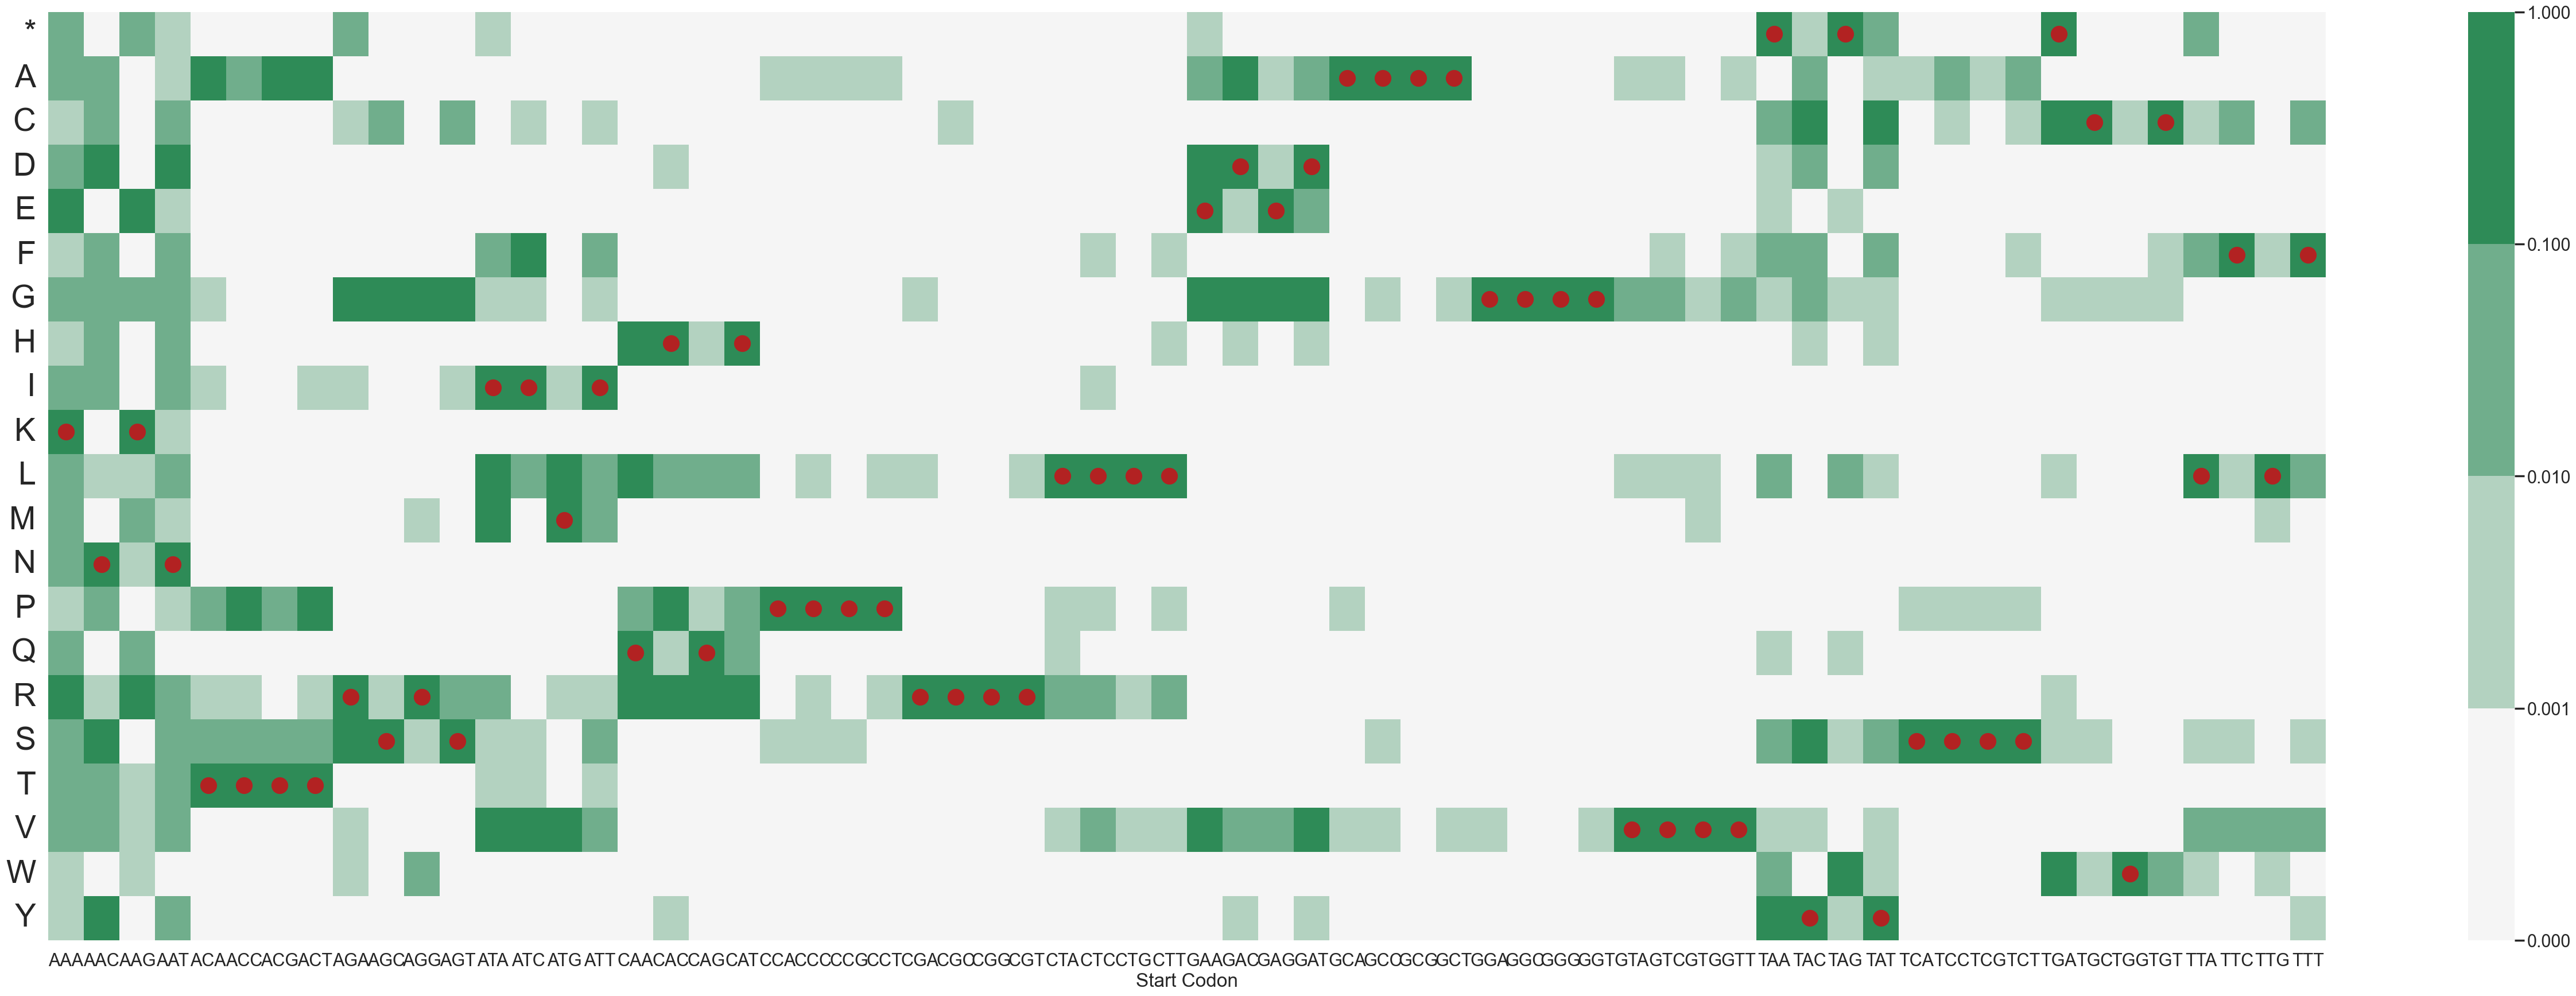

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as cl
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter

# Define start and end colors for the gradient
start_color = cl.to_rgb('whitesmoke')  # Light color
end_color = cl.to_rgb('seagreen')      # Dark color

# Create a colormap with a gradient from start_color to end_color
cmap = cl.LinearSegmentedColormap.from_list('custom_gradient', [start_color, end_color])

# Generate a list of gradient colors for the colormap
n_colors = 4  # Number of discrete colors in the gradient
gradient_colors = [cl.rgb2hex(cmap(i / (n_colors - 1))) for i in range(n_colors)]


# Set up the plot
plt.figure(figsize=(64, 21))
sns.set_theme()
sns.set_context("poster")
sns.set_style('white')

# Define the gradient colors and bounds for the colormap
colors = [gradient_colors[k] for k in range(n_colors)]
bounds = [0] + [10**-k for k in range(n_colors-1, -1, -1)]

# Create a colormap and normalization based on the bounds
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

# Create the heatmap with the normalized colormap
ax = sns.heatmap(df_proba_prot_index.transpose().sort_index(), cmap=cmap,norm=norm)
# ax = sns.heatmap(df_proba_prot_index.transpose().sort_index(), cmap=cmap, cbar=False, norm=norm)




# Initialize a matrix for start codons with shape (21, 64)
start_codon_matrix = np.zeros((21, 64))
x = []  # List to hold codons
count = -1

# Iterate over all combinations of bases to populate the start_codon_matrix
for k, base_k in enumerate(['A', 'C', 'G', 'T']):
    for i, base_i in enumerate(['A', 'C', 'G', 'T']):
        for j, base_j in enumerate(['A', 'C', 'G', 'T']):
            count += 1
            x.append(base_k + base_i + base_j)  # Create a codon string
            # Mark the position in the matrix if the amino acid matches
            for l, amino in enumerate(sorted(set(genetic_code.values()))):
                if amino == genetic_code[base_k + base_i + base_j]:
                    start_codon_matrix[l, count] = 1

# Add markers to the heatmap where the start_codon_matrix has 1s
for i in range(21):
    for j in range(64):
        if start_codon_matrix[i, j] == 1:
            ax.plot(j + 0.5, i + 0.5, 'o', color='firebrick', markersize=20)  # 'o' for circle marker

# Customize tick labels
ax.set_yticklabels(sorted(set(genetic_code.values())), rotation=0, fontsize=40)
ax.set_xticklabels(x, rotation=0)

# Save and show the heatmap plot
plt.savefig(f'Figures/Codon_Table/Codon_Table_{n_colors}_colors.png', dpi=600)
plt.savefig(f'Figures/Codon_Table/Codon_Table_{n_colors}_colors.svg')
plt.show()